In [65]:
import torch
import numpy as np
from torch import nn
from sklearn.datasets import make_circles

# Data review

In [35]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.075, random_state=42)

In [36]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.72715766  0.26569204]
 [-0.70637407  0.18798259]
 [-0.84794219  0.28280519]
 [-0.47339167  0.64641446]
 [ 0.44984546 -0.89270071]]

First 5 y labels:
[1 1 1 1 0]


In [37]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.727158,0.265692,1
1,-0.706374,0.187983,1
2,-0.847942,0.282805,1
3,-0.473392,0.646414,1
4,0.449845,-0.892701,0
5,-0.457684,0.747541,1
6,-0.019042,0.808467,1
7,0.744760,0.174234,1
8,-0.183654,-0.807813,1
9,-0.097029,1.068080,0


In [38]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

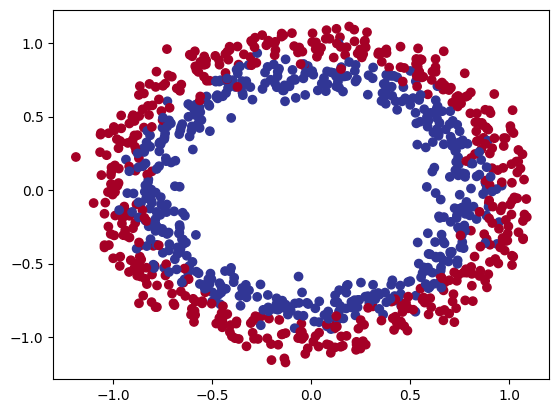

In [39]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [40]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [41]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.72715766 0.26569204] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


# Turn data to tensors

In [42]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7272,  0.2657],
         [-0.7064,  0.1880],
         [-0.8479,  0.2828],
         [-0.4734,  0.6464],
         [ 0.4498, -0.8927]]),
 tensor([1., 1., 1., 1., 0.]))

In [43]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 20% test, 80% train
    random_state=42
) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Model building

In [45]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        out = self.layer_1(x)
        out = self.layer_2(out)
        return out # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [55]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2142],
        [-0.1808],
        [ 0.1168],
        [-0.3261],
        [ 0.6827],
        [ 0.6901],
        [ 0.2321],
        [ 0.4203],
        [ 0.1548],
        [-0.2194]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [56]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [57]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Training the model

In [58]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2142],
        [-0.1808],
        [ 0.1168],
        [-0.3261],
        [ 0.6827]], device='cuda:0', grad_fn=<SliceBackward0>)

In [59]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4466],
        [0.4549],
        [0.5292],
        [0.4192],
        [0.6644]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [60]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [61]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71547, Accuracy: 51.62% | Test loss: 0.70340, Test acc: 50.50%
Epoch: 10 | Loss: 0.71410, Accuracy: 51.50% | Test loss: 0.70235, Test acc: 51.00%
Epoch: 20 | Loss: 0.71288, Accuracy: 51.25% | Test loss: 0.70143, Test acc: 50.00%
Epoch: 30 | Loss: 0.71177, Accuracy: 51.50% | Test loss: 0.70061, Test acc: 50.50%
Epoch: 40 | Loss: 0.71077, Accuracy: 51.38% | Test loss: 0.69989, Test acc: 50.00%
Epoch: 50 | Loss: 0.70986, Accuracy: 51.62% | Test loss: 0.69924, Test acc: 49.00%
Epoch: 60 | Loss: 0.70904, Accuracy: 51.75% | Test loss: 0.69866, Test acc: 49.00%
Epoch: 70 | Loss: 0.70829, Accuracy: 51.62% | Test loss: 0.69814, Test acc: 49.50%
Epoch: 80 | Loss: 0.70760, Accuracy: 51.62% | Test loss: 0.69767, Test acc: 49.50%
Epoch: 90 | Loss: 0.70697, Accuracy: 51.50% | Test loss: 0.69725, Test acc: 50.00%


# Predictions and evaluation

In [66]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


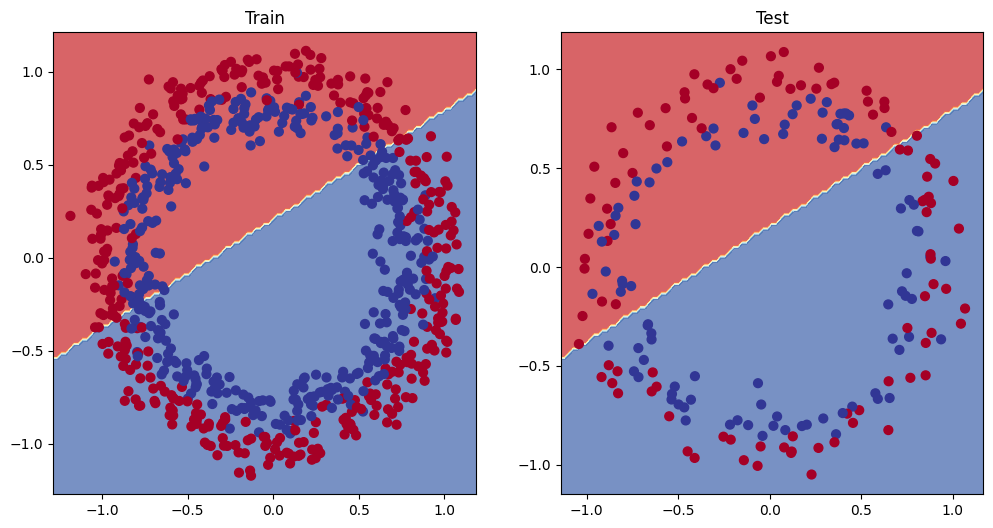

In [67]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Model improvement

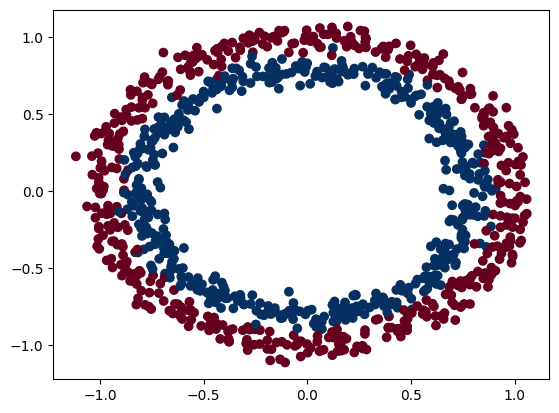

In [133]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.05,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [134]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6772, -0.4456],
         [ 0.6030, -0.7328],
         [-1.0219, -0.1066],
         [-0.9613, -0.2265],
         [-0.1646,  0.8112]]),
 tensor([1., 0., 0., 0., 1.]))

In [135]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=15)
        self.layer_2 = nn.Linear(in_features=15, out_features=15)
        self.layer_3 = nn.Linear(in_features=15, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        
        return out

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
)


In [136]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [137]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69394, Accuracy: 45.50% | Test Loss: 0.69496, Test Accuracy: 44.00%
Epoch: 100 | Loss: 0.68884, Accuracy: 59.50% | Test Loss: 0.69118, Test Accuracy: 57.00%
Epoch: 200 | Loss: 0.68487, Accuracy: 61.38% | Test Loss: 0.68816, Test Accuracy: 54.50%
Epoch: 300 | Loss: 0.67957, Accuracy: 63.25% | Test Loss: 0.68472, Test Accuracy: 55.00%
Epoch: 400 | Loss: 0.67138, Accuracy: 62.38% | Test Loss: 0.67892, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.65765, Accuracy: 65.88% | Test Loss: 0.66837, Test Accuracy: 58.50%
Epoch: 600 | Loss: 0.63419, Accuracy: 77.00% | Test Loss: 0.64924, Test Accuracy: 70.50%
Epoch: 700 | Loss: 0.59132, Accuracy: 89.75% | Test Loss: 0.61408, Test Accuracy: 83.00%
Epoch: 800 | Loss: 0.51873, Accuracy: 94.12% | Test Loss: 0.55361, Test Accuracy: 88.50%
Epoch: 900 | Loss: 0.41427, Accuracy: 95.38% | Test Loss: 0.46772, Test Accuracy: 88.50%


In [138]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

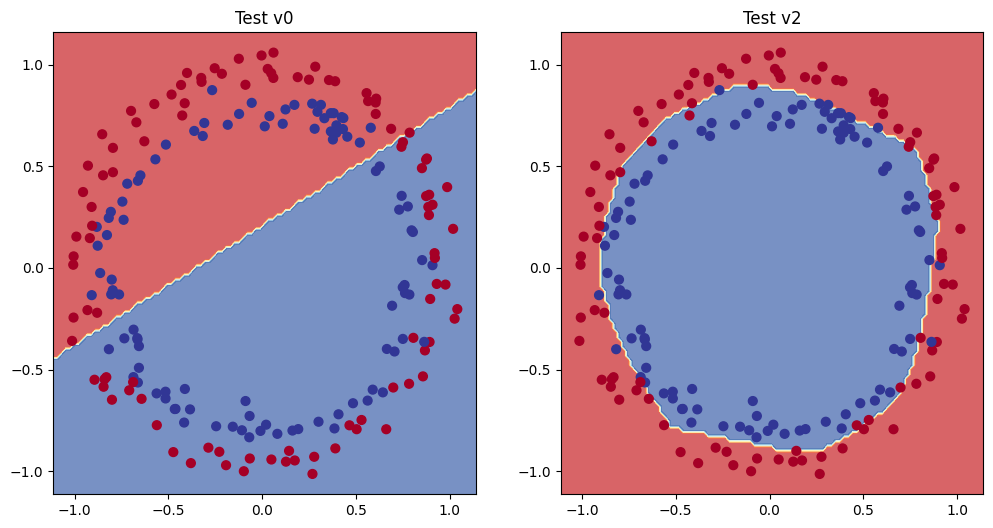

In [140]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test v0")
plot_decision_boundary(model_0, X_test, y_test) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test v2")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Multiclassification

tensor([[5.9554e-03, 8.2803e+00],
        [2.0221e+00, 6.1744e+00],
        [2.4955e+00, 2.4699e+00],
        [3.1308e+00, 5.9401e+00],
        [2.2087e+00, 7.3168e+00]]) tensor([1, 3, 1, 3, 1])


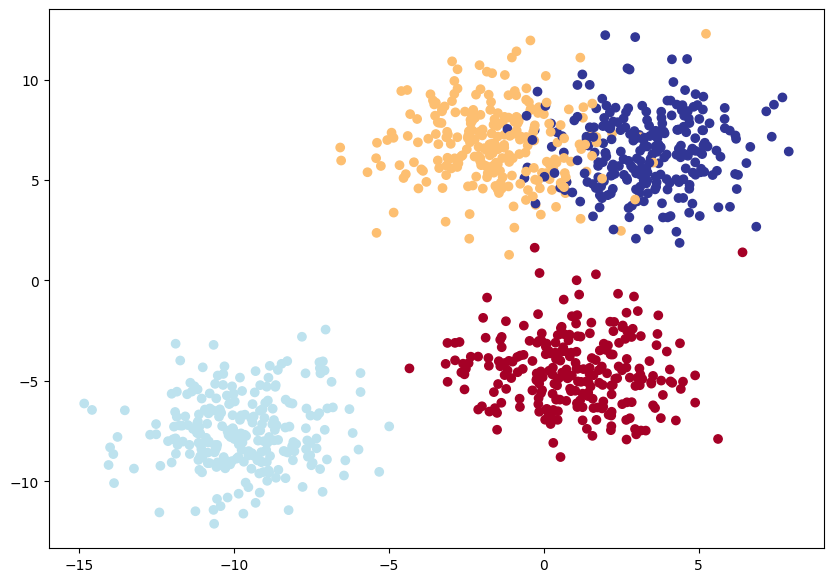

In [173]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 100

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.75, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [174]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [175]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.layer(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features=NUM_FEATURES, 
    output_features=NUM_CLASSES, 
    hidden_units=8
).to(device)

model_4

BlobModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [176]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [177]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.1826, -1.1122, -0.8413, -0.2403],
        [-0.8759, -0.9713, -1.8112, -1.2094],
        [-0.7192, -1.1208, -1.6423, -0.9734],
        [ 0.0668, -0.4262, -0.0267, -0.0297],
        [ 0.2211, -0.2901,  0.1042,  0.0182]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [178]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.0408e-01, -4.1479e-01, -4.8786e-02,  2.8710e-03],
        [ 1.4447e-01, -4.3108e-01, -4.5711e-02,  2.2263e-02],
        [-2.2739e-01, -1.2075e+00, -9.5354e-01, -2.7819e-01],
        [-3.4089e-01, -9.4497e-01, -1.0285e+00, -5.4563e-01],
        [ 1.0243e-01, -4.2418e-01, -6.0439e-02, -4.4254e-04]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2979, 0.1773, 0.2556, 0.2692],
        [0.3054, 0.1718, 0.2525, 0.2703],
        [0.3559, 0.1336, 0.1722, 0.3383],
        [0.3491, 0.1908, 0.1755, 0.2845],
        [0.2992, 0.1767, 0.2542, 0.2699]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [179]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[2])
print(torch.argmax(y_pred_probs[2]))

tensor([0.3559, 0.1336, 0.1722, 0.3383], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [180]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.43857, Acc: 24.50% | Test Loss: 1.36366, Test Acc: 42.50%
Epoch: 10 | Loss: 0.99082, Acc: 68.12% | Test Loss: 1.01617, Test Acc: 65.00%
Epoch: 20 | Loss: 0.69203, Acc: 90.25% | Test Loss: 0.69635, Test Acc: 90.00%
Epoch: 30 | Loss: 0.39454, Acc: 92.62% | Test Loss: 0.39553, Test Acc: 91.50%
Epoch: 40 | Loss: 0.25250, Acc: 94.25% | Test Loss: 0.25559, Test Acc: 92.00%
Epoch: 50 | Loss: 0.19306, Acc: 95.00% | Test Loss: 0.19734, Test Acc: 93.00%
Epoch: 60 | Loss: 0.16869, Acc: 95.12% | Test Loss: 0.17220, Test Acc: 93.00%
Epoch: 70 | Loss: 0.15686, Acc: 95.12% | Test Loss: 0.15910, Test Acc: 93.00%
Epoch: 80 | Loss: 0.15018, Acc: 95.25% | Test Loss: 0.15126, Test Acc: 93.00%
Epoch: 90 | Loss: 0.14593, Acc: 95.25% | Test Loss: 0.14607, Test Acc: 93.00%


In [181]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 4.3128, -3.6145, -3.1605, -1.9593],
        [-2.5555, -4.5442,  4.1840, -4.9474],
        [-6.6556,  4.8443, -7.6396, -0.4098],
        [-5.5241, -0.6152, -7.1042,  1.2459],
        [ 4.2611, -3.5704, -3.1103, -1.9425],
        [-7.0390,  2.3922, -8.2653,  0.5712],
        [ 4.7946, -4.0794, -3.6231, -2.1727],
        [-2.2052, -3.2226,  2.9551, -3.8088],
        [-5.7212,  4.7998, -6.7806, -0.6496],
        [ 2.4657, -3.1985, -2.6234, -1.0460]], device='cuda:0')

In [182]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0], device='cuda:0')
Labels: tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0], device='cuda:0')
Test accuracy: 93.0%


In [184]:
y_pred_probs[:10]

tensor([[9.9719e-01, 3.5973e-04, 5.6643e-04, 1.8828e-03],
        [1.1816e-03, 1.6172e-04, 9.9855e-01, 1.0806e-04],
        [1.0079e-05, 9.9479e-01, 3.7674e-06, 5.1986e-03],
        [9.9211e-04, 1.3441e-01, 2.0432e-04, 8.6439e-01],
        [9.9696e-01, 3.9581e-04, 6.2708e-04, 2.0161e-03],
        [6.9006e-05, 8.6060e-01, 2.0245e-05, 1.3931e-01],
        [9.9870e-01, 1.3980e-04, 2.2065e-04, 9.4100e-04],
        [5.6890e-03, 2.0567e-03, 9.9111e-01, 1.1444e-03],
        [2.6849e-05, 9.9568e-01, 9.3072e-06, 4.2805e-03],
        [9.6202e-01, 3.3364e-03, 5.9297e-03, 2.8712e-02]], device='cuda:0')

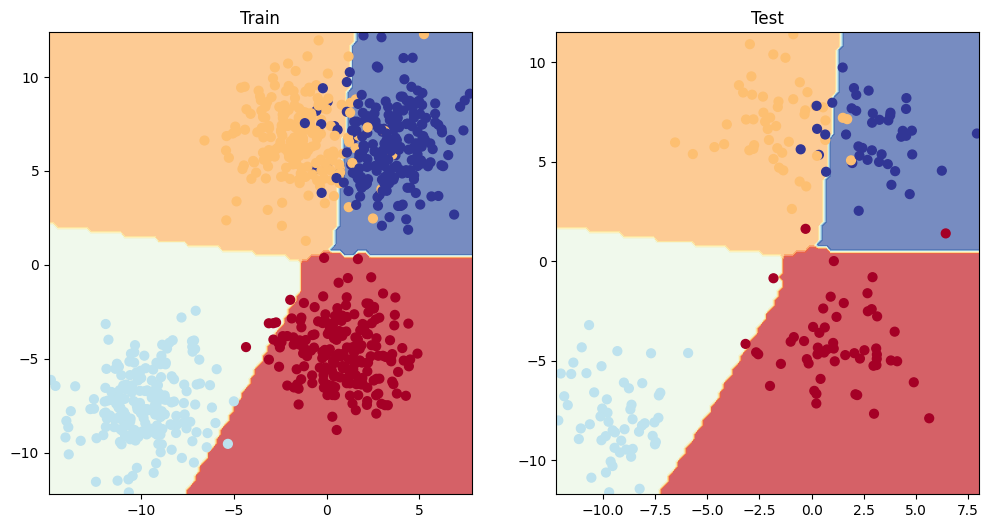

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)